In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 画图的主题设计
sns.set_theme()
sns.set_context('notebook')

# 数据获取
数据中有5个维度的字段，其分别表示用户id、商品id、用户行为类型、商品类别以及时间信息。充分理解这些字段的含义是数据分析的基础，这里我们列出这些字段的主要信息：

| 字段          | 字段说明                     | 提取说明                             |
|---------------|-----------------------------|-------------------------------------|
| `user_id`     | 用户标识                     | 抽样和字段脱敏                       |
| `item_id`     | 商品标识                     | 字段脱敏                             |
| `behavior_type` | 用户对商品的行为类型         | 包括浏览、收藏、加购物车、购买，对应取值分别是1、2、3、4 |
| `item_category` | 商品分类标识                 | 字段脱敏                             |
| `time`        | 行为时间                     | 精确到小时级别                       |

In [2]:
data_user = pd.read_csv("../dataset/alibaba_eshop_user_action.zip")
data_user.head(20)

,user_id,item_id,behavior_type,item_category,time
0,98047837,232431562,1,4245,2014-12-06 02
1,97726136,383583590,1,5894,2014-12-09 20
2,98607707,64749712,1,2883,2014-12-18 11
3,98662432,320593836,1,6562,2014-12-06 10
4,98145908,290208520,1,13926,2014-12-16 21
5,93784494,337869048,1,3979,2014-12-03 20
6,94832743,105749725,1,9559,2014-12-13 20
7,95290487,76866650,1,10875,2014-11-27 16
8,96610296,161166643,1,3064,2014-12-11 23
9,100684618,21751142,3,2158,2014-12-05 23


In [3]:
# 查看数据集量级
print('整体数据的大小为: ', len(data_user))

print('数据集中用户数量是: ', len(set(data_user['user_id'])))
print('数据集中商品数量是: ', len(set(data_user['item_id'])))
print('数据集中商品类别数量是: ', len(set(data_user['item_category'])))

整体数据的大小为:  12256906
数据集中用户数量是:  10000
数据集中商品数量是:  2876947
数据集中商品类别数量是:  8916


In [4]:
# 查看数据缺失情况
data_user.isnull().sum()

user_id          0
item_id          0
behavior_type    0
item_category    0
time             0
dtype: int64

In [5]:
# 分割天(date)和小时(hour)
data_user['date'] = data_user['time'].map(lambda x: x.split(' ')[0])
data_user['hour'] = data_user['time'].map(lambda x: x.split(' ')[1])
data_user.head()

,user_id,item_id,behavior_type,item_category,time,date,hour
0,98047837,232431562,1,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,13926,2014-12-16 21,2014-12-16,21


In [6]:
# 查看字段类型：
data_user.dtypes

user_id           int64
item_id           int64
behavior_type     int64
item_category     int64
time             object
date             object
hour             object
dtype: object

In [7]:
# 数据类型转换
data_user['user_id'] = data_user['user_id'].astype('object')
data_user['item_id'] = data_user['item_id'].astype('object')
data_user['item_category'] = data_user['item_category'].astype('object')
data_user['date'] = pd.to_datetime(data_user['date'])
data_user['hour'] = data_user['hour'].astype('int64')

In [8]:
data_user.dtypes

user_id                  object
item_id                  object
behavior_type             int64
item_category            object
time                     object
date             datetime64[ns]
hour                      int64
dtype: object

# EDA
## Part1: 流量分析

### 1. 基于天级别访问流量分析
我们先从宏观的流量分析入手，来看看能发现哪有有趣的规律。我们主要关注访问量(PV)与独立访问量(UV)：
+ 访问量(PV)：基于用户每次对淘宝页面的刷新次数，用户每刷新一次页面或者打开新的页面就记录就算一次访问。
+ 独立访问量(UV)：一个用户若多次访问淘宝只记录一次

In [9]:
# 计算PV: PageView , UV: UniqueView
# PV: select count(user_id) from data_user group by "date";
# UV: select count(distinct(user_id)) from data_user group by "date";

pv_daily = data_user.groupby('date')['user_id'].count()
pv_daily = pv_daily.reset_index() 
pv_daily = pv_daily.rename(columns={'user_id':'pv_daily'})
pv_daily

,date,pv_daily
0,2014-11-18,366701
1,2014-11-19,358823
2,2014-11-20,353429
3,2014-11-21,333104
4,2014-11-22,361355
5,2014-11-23,382702
6,2014-11-24,378342
7,2014-11-25,370239
8,2014-11-26,360896
9,2014-11-27,371384


In [10]:
# 计算UV
uv_daily = data_user.groupby('date')['user_id'].apply(lambda x: len(x.unique()))
uv_daily = uv_daily.reset_index()
uv_daily = uv_daily.rename(columns = {'user_id':'uv_daily'})
uv_daily

,date,uv_daily
0,2014-11-18,6343
1,2014-11-19,6420
2,2014-11-20,6333
3,2014-11-21,6276
4,2014-11-22,6187
5,2014-11-23,6373
6,2014-11-24,6513
7,2014-11-25,6351
8,2014-11-26,6357
9,2014-11-27,6359


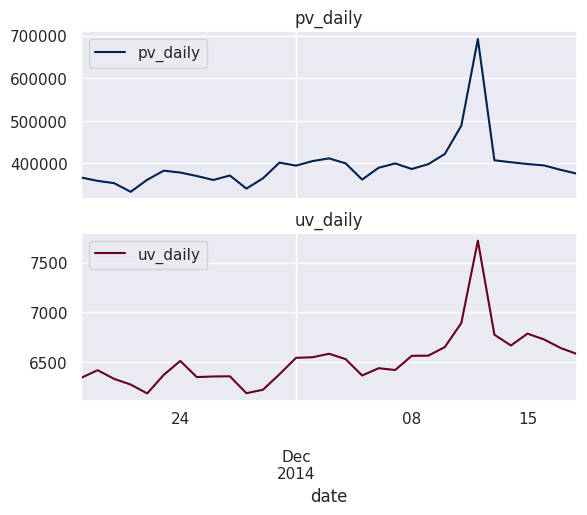

In [11]:
# 可视化
fig, axes = plt.subplots(2,1,sharex=True)
# pv_daily: pandas 对象
# Matplotlib, Pandas , histplot:  柱状图
pv_daily.plot(x='date', y='pv_daily', ax=axes[0], colormap='cividis')
uv_daily.plot(x='date', y='uv_daily', ax=axes[1], colormap='RdGy')
axes[0].set_title('pv_daily')
axes[1].set_title('uv_daily')
plt.show()

可以看出，不管是PV还是UV趋势，均在12号的时候出现了一个尖峰，这正是著名的双十二大促节的用户集中消费导致的变化。 通过简单的数据分析和可视化工具，这是我们从数据中观察到了第一个结论。

### 2. 基于小时级别访问流量分析
上面的对不同访问量进行分析，其分析的时间跨度是每天。另外从我们的直觉可以知道，用户在一天当中对淘宝的使用也是有一定规律的。为了探索这个规律，我们将按照每小时统计用户的访问量和独立访问量。同pv_daily, uv_daily分析，我们完成如下代码：

In [12]:
# 计算每小时的PV
pv_hour = data_user.groupby('hour')['user_id'].count()
pv_hour = pv_hour.reset_index()
pv_hour = pv_hour.rename(columns={'user_id':'pv_hour'})
pv_hour

,hour,pv_hour
0,0,517404
1,1,267682
2,2,147090
3,3,98516
4,4,80487
5,5,88296
6,6,158798
7,7,287337
8,8,396106
9,9,485951


In [13]:
# 计算每小时UV
uv_hour = data_user.groupby('hour')['user_id'].apply(lambda x: len(x.unique()))
uv_hour = uv_hour.reset_index()
uv_hour = uv_hour.rename(columns={'user_id':'uv_hour'})
uv_hour

,hour,uv_hour
0,0,5786
1,1,3780
2,2,2532
3,3,1937
4,4,1765
5,5,2030
6,6,3564
7,7,5722
8,8,7108
9,9,7734


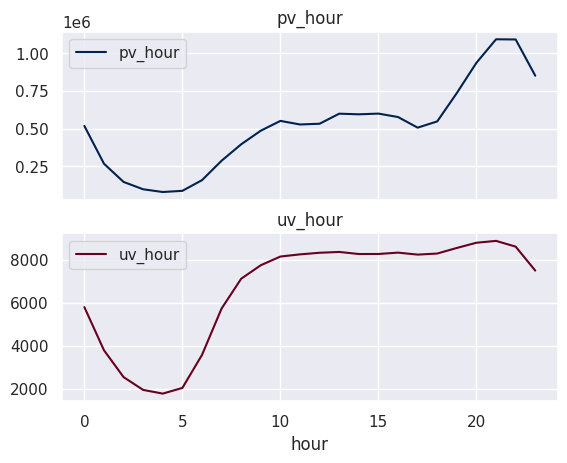

In [14]:
# 可视化
fig, axes = plt.subplots(2,1,sharex=True)
pv_hour.plot(x='hour',y='pv_hour',ax=axes[0],colormap='cividis')
uv_hour.plot(x='hour', y='uv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')
plt.show()

可以看出，PV的高峰值出现在20点之后，可能的原因是淘宝的主力消费人群是工薪阶层，这部分群体在下班后开始使用淘宝浏览购物；UV的值比较恒定，上午10点之后便没有出现大的波动，一个可能的原因是用户早晨也会刷一下淘宝，比如看看物流状态，UV值在一天之内就不会再有大的变化波动了。 另外也可以看出，凌晨2点之后，PV/UV的趋势一致，均是一天中流量最小的时间段。

从“日PV/UV”趋势看，双十二当天的总体流量会出现明显的峰值。那么双十二当天基于小时的用户访问数据会有变化吗？我们来写代码分析：

In [15]:
data_user_1212 = data_user.loc[data_user['date']=='2014-12-12']

# 计算每小时的PV
pv_hour_1212 = data_user_1212.groupby('hour')['user_id'].count().reset_index().rename(columns={'user_id':'1212_pv_hour'})
uv_hour_1212 = data_user_1212.groupby('hour')['user_id'].apply(lambda x: len(x.unique())).reset_index().rename(columns={'user_id':'1212_uv_hour'})
pv_hour_1212

,hour,1212_pv_hour
0,0,50030
1,1,22761
2,2,11754
3,3,6173
4,4,5168
5,5,6417
6,6,12820
7,7,22177
8,8,28156
9,9,32695


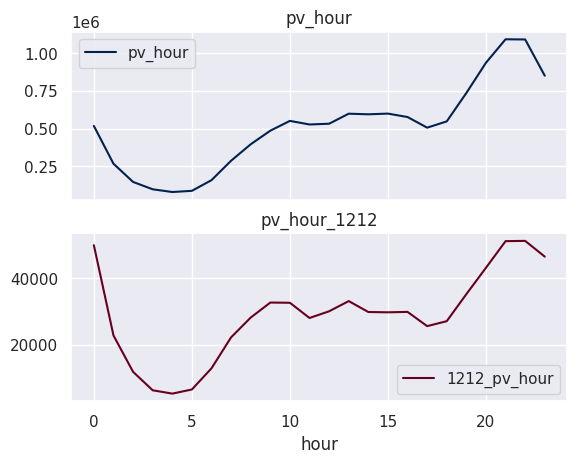

In [16]:
# 为了方便对比，我们和30日总体的小时级别PV/UV变化趋势做对比
fig, axes = plt.subplots(2,1,sharex=True)

# 对比PV
pv_hour.plot(x='hour',y='pv_hour',ax=axes[0],colormap='cividis')
pv_hour_1212.plot(x='hour', y='1212_pv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('pv_hour')
axes[1].set_title('pv_hour_1212')
plt.show()

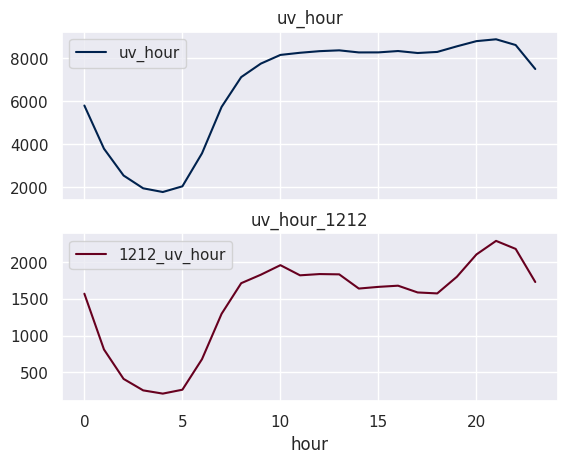

In [17]:
# 对比UV
fig, axes = plt.subplots(2,1,sharex=True)
uv_hour.plot(x='hour',y='uv_hour',ax=axes[0],colormap='cividis')
uv_hour_1212.plot(x='hour', y='1212_uv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('uv_hour')
axes[1].set_title('uv_hour_1212')
plt.show()

可以看到，双十二当天，PV变化趋与一个月内的PV变化趋势基本一致，只不过曲线不太平滑，多出来小的凸点，一个可能的原因是大促当天，有整点领券活动，通过推送等形式会有效拉动用户使用淘宝。UV变化趋势稍有不同，可以看到双十二当天在晚上8点之后UV出现了小高峰，表明了大促当天用户的消费意愿还是比较强烈。

我们再来看看4类用户行为的流量趋势：

### 不同用户行为流量分析
众所周知，淘宝用户分布广泛，不同的用户的购物行为有较大差异。比如不同的用户的登录习惯以及购买偏好，因此按照用户的角度进行分析是重要且有趣的。因此我们依旧从用户访问量的这一数据来分析不同用户的浏览淘宝的习惯。

为了获得用户的行为模式，我们主要统计在一天当中（按照每小时）用户发生的行为。因此我们使用groupby进行数据分组，方式如下：